In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

from imblearn.over_sampling import SMOTE #for SMOTE -> install package using: conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import RandomOverSampler 
from scipy import stats, integrate
import matplotlib.pyplot as plt
import ggplot
import scipy
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
#from sklearn.svm import SVR #just Testing for regression on other continous data of dataset
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2


import pylab as pl
from itertools import cycle
from sklearn import cross_validation
from sklearn.svm import SVC

features_list = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','class']
dataset1=pd.read_csv("data/Heart_Disease_Data.csv")
#dataset1=pd.read_csv("Balanced_Data.csv")

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into whi

In [2]:
# SVM requires that each data instance is represented as a vector of real numbers
# If you already have numeric dtypes (int8|16|32|64,float64,boolean) you can convert it to another "numeric" dtype using Pandas .astype() method. Demo: In [90]: df = pd.DataFrame(np.random.randint(10**5,10**7,(5,3)),columns=list('abc'), dtype=np.int64) In [91]: df Out[91]: a b c 0 9059440 9590567 2076918 1 5861102 4566089 1947323 2 6636568 162770 2487991 3 6794572 5236903 5628779 4 470121 4044395 4546794 In [92]: df.dtypes Out[92]: a int64 b int64 c int64 dtype: object In [93]: df['a'] = df['a'].astype(float) In [94]: df.dtypes Out[94]: a float64 b int64 c int64 dtype: object It won't work for object (string) dtypes, that can't be converted to numbers: In [95]: df.loc[1, 'b'] = 'XXXXXX' In [96]: df Out[96]:...
# Just make everything numeric for ease, later we will convert to ordinal/one-hot encoding.
dataset1 = dataset1.convert_objects(convert_numeric=True)
dataset1 = dataset1.astype('float')

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


#### count missing value in terms of colunms #######

In [3]:
#dataset.shape[0] - dataset.count()
print(dataset1.isnull().any())
dataset1 = dataset1.replace('?', np.nan)

age               False
sex               False
cp                False
trestbps          False
chol              False
fbs               False
restecg           False
thalach           False
exang             False
oldpeak           False
slop              False
ca                 True
thal               True
pred_attribute    False
dtype: bool


### Preliminary Processing

In [4]:
# based on https://pdfs.semanticscholar.org/daa0/f01f96a89fcfc5f41a2da67fb2a8966900ab.pdf 
# these features, based on reading, may be important but have to be confirmed too by statistical methods:
Genetic_Based_Decision = dataset1[['cp','trestbps', 'restecg', 'thalach', 'ca', 'thal']]

In [5]:
# Two variables are discrete/ordinal: ca (number of major vessels colored by fluoroscopy) and num (diagnosis of heart disease)
# Three can be directly viewed as 1 hot (because binary): 'sex':'male', 'fbs':'fasting blood sugar', 'exang':'exercise induced angina'

# which leaves 4 for one-hot encoding. problem is that the values aren't unique, so have to manually
# make extra columns:

dataset1["cp"] = dataset1["cp"].replace([1,2,3,4], ["typical angina", "atypical angina", "non-angina", "asymptomatic angina"])
dataset1["restecg"] = dataset1["restecg"].replace([0,1,2], ["normalresecg", "ST-T wave abnormality", "left ventricular hypertrophy"])
dataset1["slop"] = dataset1["slop"].replace([1,2,3], ["upsloping", "flat", "downsloping"])
dataset1["thal"] = dataset1["thal"].replace([3,6,7], ["normalthal", "fixed defect", "reversible defect"])

x = dataset1[['cp', 'restecg', 'slop', 'thal']]
for column in ['cp', 'restecg', 'slop', 'thal']:
    one_hot = pd.get_dummies(dataset1[column])
    dataset1 = dataset1.drop(column, axis=1)
    dataset1 = dataset1.join(one_hot)

In [6]:
### Extract features and labels from dataset for local testing:
dataset1.dropna(inplace=True, axis=0, how="any")
Y=dataset1["pred_attribute"]
dataset1 = dataset1.drop("pred_attribute", axis=1)
X=dataset1

In [7]:
# evaluate the model by splitting into train and test sets  #Edit by ryan, we aim to do 3 traditional sets in the end, this first split is 80/20
features_train, features_test, labels_train, labels_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [8]:
features_train_df = pd.DataFrame(features_train)
#features_train_df.to_csv('features_train.csv', index=False)

features_test_df = pd.DataFrame(features_test)
#features_test_df.to_csv('features_test.csv', index=False)

labels_train_df = pd.DataFrame(labels_train)
labels_train_df.to_csv('data/labels_train.csv', index=False)

labels_test_df = pd.DataFrame(labels_test)
labels_test_df.to_csv('data/labels_test.csv', index=False)

# Modelling And Training

We have an relatively small dataset. Therefore, we should do our feature selection based on a cross-
validated set. 

## Standard Scaler (by David)
SVC Models are only any good when the data is scaled. Lets scale the data and build the model

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer

scaler = MinMaxScaler()
Standard_scaler = StandardScaler()
Robust_scaler = preprocessing.RobustScaler(quantile_range=(25, 75))
Quantile_scalar = preprocessing.QuantileTransformer(output_distribution='normal')

features_train = Standard_scaler.fit_transform(features_train)
features_test = Standard_scaler.transform(features_test)


features_train.shape

(209, 22)

# Balancing only on the training set, not the validation set
Unfortunately SMOTE categorial implementation is not really implemented
We will do simple oversampling -> Done using external program SPSS 

In [10]:
# Export data to files for external program to balance the data

#without features selection
merged = np.concatenate((features_train, labels_train.reshape((-1, 1))), axis=1)
merged_df = pd.DataFrame(merged) 
merged_df.to_csv("data/train_NoEng_NB.csv", index=False)



#features_train_009
 
#features_train_04 

#features_train_009_pca 

#features_train_04_pca

/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [11]:
df = pd.read_csv("data/train_noEng_Balanced.csv")

labels_train_df = df.iloc[:, 22:23]
df.drop(df.columns[[-1,]], axis=1, inplace=True)

features_train = df.as_matrix()
labels_train = labels_train_df.as_matrix()

print(features_train)
print(labels_train)

[[-0.804517  0.694456 -1.083678 ... -0.235702  0.93063  -0.819756]
 [ 0.535276  0.694456  2.08476  ... -0.235702 -1.074541  1.219875]
 [ 0.535276  0.694456  2.08476  ... -0.235702 -1.074541  1.219875]
 ...
 [-0.916166  0.694456  0.445913 ... -0.235702 -1.074541  1.219875]
 [-0.916166  0.694456  0.445913 ... -0.235702 -1.074541  1.219875]
 [ 0.311977 -1.439975 -0.209626 ... -0.235702  0.93063  -0.819756]]
[[0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [1.]
 [1.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [0.]
 [3.]
 [3.]
 [3.]
 [3.]
 [1.]
 [1.]
 [1.]
 [3.]
 [3.]
 [3.]
 [3.]
 [0.]
 [2.]
 [2.

In [12]:
from sklearn.metrics import accuracy_score

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
#from sklearn import grid_search
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import reciprocal, uniform


def checkmetrics(pred, labels_test, name):
    sns.set()
    print('The accuracy of ', name, 'is: ', accuracy_score(pred, labels_test))
    matrix = confusion_matrix(labels_test, pred)
    ax = sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
    print(ax)
    print(classification_report(pred, labels_test))

## Baseline Appoarch - Default Params - 5 fold X-validation

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d arr

The train score: 0.906764168190128 with parameters: {}
The accuracy of  C-Support Vector Classification is:  0.5111111111111111
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.74      0.87      0.80        45
        1.0       0.15      0.13      0.14        15
        2.0       0.44      0.21      0.29        19
        3.0       0.11      0.10      0.11        10
        4.0       0.00      0.00      0.00         1

avg / total       0.50      0.51      0.49        90



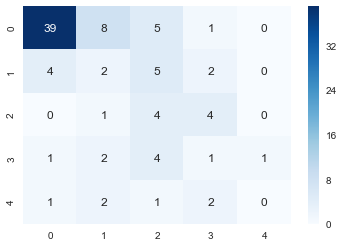

In [13]:
#svm.SVC  C-Support Vector Classification.
parameters ={
#    'C': [0.1,1], 
#    'gamma': [0.00001,0.01,0.05,0.1,0.2,0.5,1,2,3,4,5],
#    "class_weight": ['balanced', None]
}
SVM = svm.SVC()

#param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
#grid_search_cv = RandomizedSearchCV(SVM, param_distributions, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)

grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train, labels_train)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train, labels_train)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test)

checkmetrics(pred, labels_test, 'C-Support Vector Classification')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d arr

The train score: 0.6727605118829981 with parameters: {}
The accuracy of  Linear Support Vector Classification is:  0.5333333333333333
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.77      0.87      0.82        47
        1.0       0.08      0.11      0.09         9
        2.0       0.22      0.18      0.20        11
        3.0       0.44      0.24      0.31        17
        4.0       0.00      0.00      0.00         6

avg / total       0.52      0.53      0.52        90



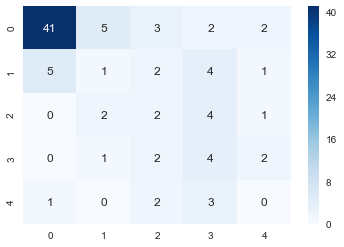

In [14]:
#LinearSVC Linear Support Vector Classification

parameters = {
#   'C': [0.1,0.2,0.5,1,2,3,4,5],
#   "class_weight": ['balanced', None]
}
SVM = LinearSVC()
grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train, labels_train)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train, labels_train)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test)

checkmetrics(pred, labels_test, 'Linear Support Vector Classification')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidleonardi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d arr

The train score: 1.0 with parameters: {'nu': 0.1}
The accuracy of  Nu-Support Vector Classification is:  0.5444444444444444
AxesSubplot(0.125,0.125;0.62x0.755)
             precision    recall  f1-score   support

        0.0       0.83      0.80      0.81        55
        1.0       0.08      0.08      0.08        12
        2.0       0.22      0.15      0.18        13
        3.0       0.22      0.22      0.22         9
        4.0       0.00      0.00      0.00         1

avg / total       0.57      0.54      0.56        90



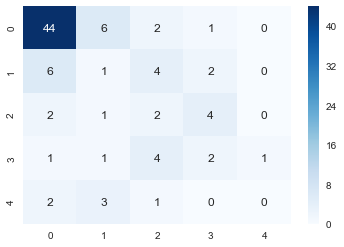

In [15]:
# sklearn.svm.NuSVC Nu-Support Vector Classification
# defaults: nu=0.5, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)
parameters = {
    'nu': [0.1] #other larger nu values is "not fleasible"
#   'C': [0.1,0.2,0.5,1,2,3,4,5],
#    "class_weight": ['balanced', None]
}
SVM = NuSVC()
grid_search_cv = GridSearchCV(SVM, parameters, cv=5,n_jobs=-1, return_train_score=True, refit=True,verbose=1)
grid_search_cv.fit(features_train, labels_train)
resultsdf=pd.DataFrame(grid_search_cv.cv_results_)
print("The train score:", str(grid_search_cv.score(features_train, labels_train)), "with parameters:", grid_search_cv.best_params_)
pred = grid_search_cv.best_estimator_.predict(features_test)

checkmetrics(pred, labels_test, 'Nu-Support Vector Classification')